In [4]:
from sqlalchemy import create_engine
from sklearn import ensemble, metrics
from IPython.display import Image
from subprocess import check_call
from pandas import *
import numpy
import matplotlib.pylab as plot

%matplotlib inline

In [5]:
# Connect to Postgres
rdbms = 'postgresql'
host = 'localhost'
port = '5432'
database = 'jupyter'
user = 'jupyter'
password = 'jupyter'

credentials = (rdbms, user, password, host, port, database)
connection_string = "%s://%s:%s@%s:%s/%s" % credentials
engine = create_engine(connection_string)

In [6]:
# Load data from Postgres to dataframe
query = """
  select *
  from iris
"""
iris_data = pandas.read_sql_query(query, con=engine)

In [7]:
# Create dummy variables for categories
code = {
    'Iris-setosa': 0,
    'Iris-virginica': 1,
    'Iris-versicolor': 2
}
iris_data['code'] = iris_data['class'].apply(lambda x: code[x])

In [8]:
# Select training, test data
training = iris_data.sample(120)
test = iris_data.drop(training.index.values)

In [9]:
# Massage training data into numpy arrays
dimensions = training.columns.values[:4]
training_data = training.as_matrix(dimensions)
training_target = training['class'].values

In [10]:
# Massage test data into numpy arrays
dimensions = test.columns.values[:4]
test_data = test.as_matrix(dimensions)
test_target = test['class'].values

In [15]:
# Train random forest
classifier_settings = {
    'n_estimators': 1000,
    'min_samples_split': 2,
    'max_depth': None,
    'random_state': 0
}

# Note the double-splat operator to decompose the dictionary
classifier = ensemble.RandomForestClassifier(**classifier_settings)
classifier.fit(training_data, training_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
# Make predictions
predicted = classifier.predict(test_data)
expected = test_target

In [17]:
# Print results
print(metrics.classification_report(expected, predicted))
print("\nConfusion Matrix")
print(metrics.confusion_matrix(expected, predicted))

print("\nFeatures sorted by their score:")
print(
    sorted(
        zip(
            map(lambda x: round(x, 4), classifier.feature_importances_),
            training.columns
        ),
        reverse=True
    )
)

             precision    recall  f1-score   support

Iris-setosa       1.00      1.00      1.00        13
Iris-versicolor       1.00      0.57      0.73         7
Iris-virginica       0.77      1.00      0.87        10

avg / total       0.92      0.90      0.89        30


Confusion Matrix
[[13  0  0]
 [ 0  4  3]
 [ 0  0 10]]

Features sorted by their score:
[(0.4725, u'petal_length'), (0.4231, u'petal_width'), (0.0811, u'sepal_length'), (0.0233, u'sepal_width')]


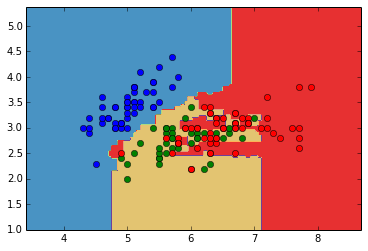

In [18]:
# Scatter plot in blossom space
species = iris_data.groupby('class')
fig, ax = plot.subplots()

x, y = 'sepal_length', 'sepal_width'

flat_data = training.as_matrix([x, y])
flat_target = training['code']

flat_classifier = ensemble.RandomForestClassifier(**classifier_settings).fit(flat_data, flat_target)

plot_step = 0.02
x_min, x_max = flat_data[:, 0].min() - 1, flat_data[:, 0].max() + 1
y_min, y_max = flat_data[:, 1].min() - 1, flat_data[:, 1].max() + 1
xx, yy = numpy.meshgrid(
    numpy.arange(x_min, x_max, plot_step),
    numpy.arange(y_min, y_max, plot_step)
)

Z = flat_classifier.predict(numpy.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plot.contourf(xx, yy, Z, cmap=plot.cm.Paired)

for name, group in species:
    ax.plot(
        group[x],
        group[y],
        linestyle='',
        marker='o',
        label=name
    )